In this demo, we first show how to use the Arrow `Dataset` API `RadosParquetFileFormat` API to scan parquet files by pushing down scan opertations into Ceph and then we show how to use the `Dataset` API to process parquet files containing NanoEvents stored in Ceph in parallel through Coffea using Dask.

## Exploring RadosParquetFileFormat with PyArrow

We import the Dataset API and the Parquet API from PyArrow.

In [1]:
import pyarrow
import pyarrow.dataset as ds
import pyarrow.parquet as pq

Now, we will instantiate the `RadosParquetFileFormat`. Upon instantiation, the connection to the Ceph cluster is made under the hood. The connection is closed automatically upon object destruction. The `RadosParquetFileFormat` API currently takes the Ceph configuration file as input. It inherits from the `FileFormat` API and uses the `DirectObjectAccess` API under the hood to interact with the underlying objects that make up a file in CephFS.

In [2]:
rados_format = ds.RadosParquetFileFormat(b"/etc/ceph/ceph.conf")

Since, we mount CephFS, we use the `FileSystemDataset` that comes out of the box with Apache Arrow for instantiating our dataset, as by mounting CephFS we have just another directory of Parquet files. Having the suitability of using the `FileSystemDataset`, we just can start pushing down scan operations to our Parquet files by just plugging in `RadosParquetFileFormat` in the format paramter. 

In [3]:
dataset = ds.dataset("file:///mnt/cephfs/nyc", format=ds.RadosParquetFileFormat(b"/etc/ceph/ceph.conf"))

Now we apply some projections and filters on the dataset.

In [4]:
dataset.to_table(columns=["total_amount", "fare_amount"], filter=(ds.field("trip_distance") > 20.0)).to_pandas()

,total_amount,fare_amount
0,75.84,52.00
1,69.99,52.00
2,59.84,53.00
3,68.50,53.50
4,70.01,52.00
...,...,...
376,78.88,67.00
377,64.84,58.50
378,0.31,0.01
379,58.80,57.50


## Install Dask

We will be using Dask workers for parallel execution. So, let's install it.

In [5]:
!pip3 install dask[distributed]
!pip3 install 'fsspec>=0.3.3'

## Import the required modules

Import `uproot`, `awkward`, `coffea`.

In [6]:
import uproot
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

## Define a Processor instance

The processor implementation given below has been taken from [here](https://github.com/CoffeaTeam/coffea/blob/master/binder/nanoevents.ipynb).

In [7]:
class MyZPeak(processor.ProcessorABC):
    def __init__(self):
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("mass", "Z mass", 60, 60, 120),
        )
    
    @property
    def accumulator(self):
        return self._histo
    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        mmevents = events[
            (ak.num(events.Muon) == 2)
            & (ak.sum(events.Muon.charge, axis=1) == 0)
        ]
        zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
        out.fill(
            dataset=events.metadata["dataset"],
            mass=zmm.mass,
        )
        return out
    
    def postprocess(self, accumulator):
        return accumulator

## Convert a Root file containing NanoEvents to a Parquet file

In [8]:
ak.to_parquet(
    uproot.lazy("../tests/samples/nano_dy.root:Events"),
    "nano_dy.parquet",
    list_to32=True,
    use_dictionary=False,
    compression="GZIP",
    compression_level=1,
)

## Write some NanoEvents Parquet files to CephFS

Here we populate the CephFS mounted directory with the parquet files created in the previous step. In this version, we need to make sure that the individual file sizes is under 4MB which is the default object size of Ceph to ensure one-to-one mapping of files to objects, which is a requirement in the multiple-file design that we have now.

In [9]:
!mkdir -p /mnt/cephfs/nanoevents/
!cp nano_dy.parquet /mnt/cephfs/nanoevents/nano_dy.0.parquet
!cp nano_dy.parquet /mnt/cephfs/nanoevents/nano_dy.1.parquet
!cp nano_dy.parquet /mnt/cephfs/nanoevents/nano_dy.2.parquet
!cp nano_dy.parquet /mnt/cephfs/nanoevents/nano_dy.3.parquet
!cp nano_dy.parquet /mnt/cephfs/nanoevents/nano_dy.4.parquet
!cp nano_dy.parquet /mnt/cephfs/nanoevents/nano_dy.5.parquet

## Reading Nanoevents from RadosParquetFileFormat

In [10]:
events_rados_parquet = NanoEventsFactory.from_parquet("/mnt/cephfs/nanoevents/nano_dy.0.parquet", rados_parquet_options = {"is_rados_parquet": True, "ceph_config_path": "/etc/ceph/ceph.conf"}).events()
events_rados_parquet

<NanoEventsArray [<event 1:13889:3749778>, ... ] type='40 * event'>

## Running a job in parallel using Dask

The `LocalCluster()` used below creates a process pool with worker count equal to the number of cores available to the Notebook where each worker is single-threaded. The `LocalCluster` can be replaced by other cluster resource managers provided by Dask Distributed like `KuberneresCluster`, `YarnCluster`, etc. Here, we create a `LocalCluster` and get a client handle to it.

In [11]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=True, threads_per_worker=1)
client = Client(cluster)

We have added a new function called `run_rados_parquet_job` to the executor API in coffea to run jobs on Parquet files using the Arrow Dataset API under the hood. 
This API takes a `ceph_config_path` parameter, which is basically the path to the configuration file of the Ceph cluster. This API also allows just passing a single directory path and the Datasets API does the dataset discovery task by itself. The calls to the Dataset API are launced in parallel and there will one Dataset API call per file.

In [12]:
%%time
result = processor.run_rados_parquet_job(
    '/mnt/cephfs/nanoevents/',
    "Events",
    processor_instance=MyZPeak(),
    executor=processor.dask_executor,
    executor_args={"client": client, "ceph_config_path": "/etc/ceph/ceph.conf"}
)

CPU times: user 1.67 s, sys: 350 ms, total: 2.02 sCompleted |  4.7s
Wall time: 5.23 s


## Running iteratively using the `iterative_executor`

Run the same job again, but now iteratively. The calls to the Dataset API will now be sequential.

In [13]:
%%time
result = processor.run_rados_parquet_job(
    '/mnt/cephfs/nanoevents/',
    "Events",
    processor_instance=MyZPeak(),
    executor=processor.iterative_executor,
    executor_args={"ceph_config_path": "/etc/ceph/ceph.conf"}
)

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

CPU times: user 7.72 s, sys: 1.22 s, total: 8.93 s
Wall time: 13.8 s


As expected, much slower than running using Dask.

## Plotting the results



<AxesSubplot:xlabel='Z mass', ylabel='Events'>

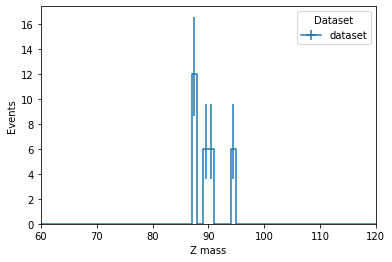

In [14]:
%matplotlib inline

hist.plot1d(result)